In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import BDay
from datetime import datetime
import os

Saving plot to: /home/yic075/CAPSTONE-stockreturn/DeepAR/experiments/t_base_model/fusion_prediction_plot.png


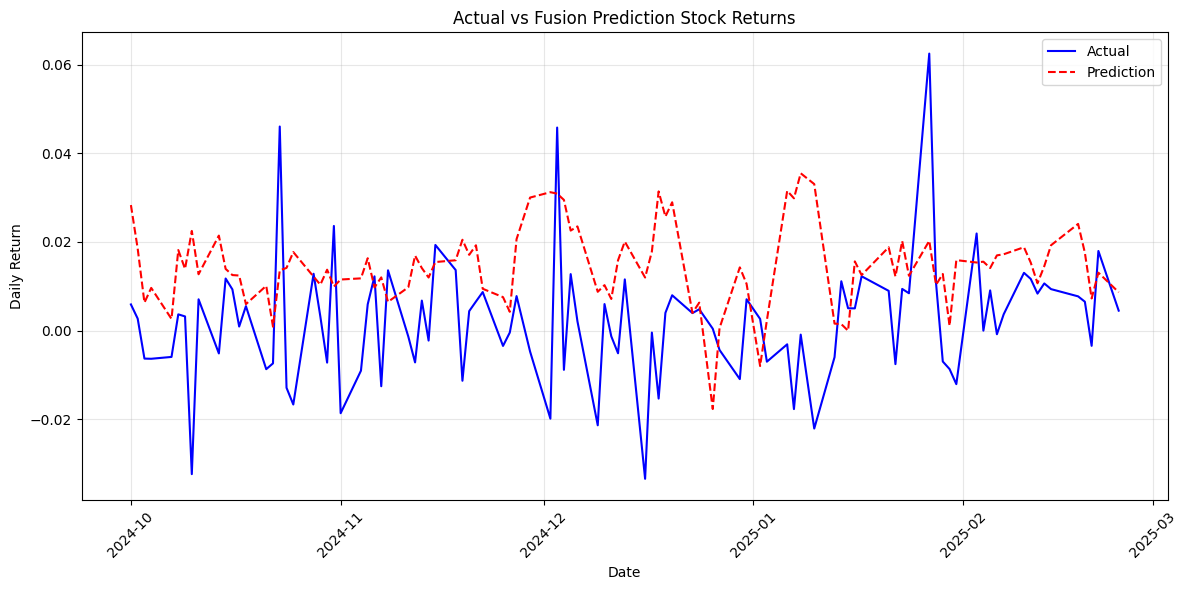

In [2]:
current_dir = os.getcwd()
root_index = current_dir.find('CAPSTONE-stockreturn')
project_root = current_dir[:root_index + len('CAPSTONE-stockreturn')]

fusion_path = os.path.join(project_root, "DeepAR", "experiments", "t_base_model", "fusion_predictions.csv")

df = pd.read_csv(fusion_path)
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['actual'], '-', label='Actual', color='blue', linewidth=1.5)
plt.plot(df['Date'], df['fusion_prediction'], '--', label='Prediction', color='red', linewidth=1.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.title('Actual vs Fusion Prediction Stock Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

save_dir = os.path.join(project_root, "DeepAR", "experiments", "t_base_model")
save_path = os.path.join(save_dir, "fusion_prediction_plot.png")
print(f"Saving plot to: {save_path}")

# 保存图表
plt.savefig(save_path, dpi=300)

# 显示图表
plt.show()

Plot saved to: /home/yic075/CAPSTONE-stockreturn/DeepAR/experiments/t_base_model/final_prediction_plot.png


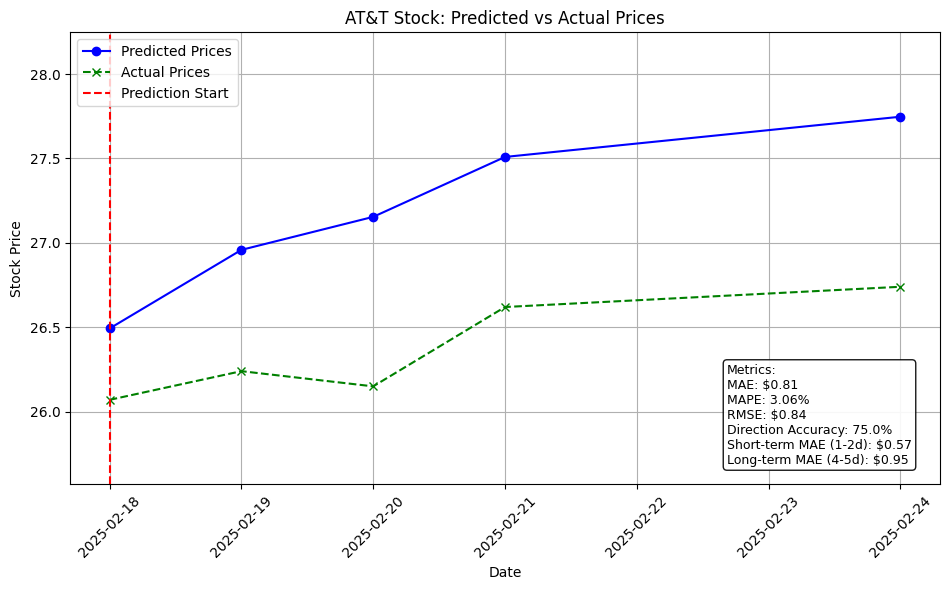

In [4]:
current_dir = os.getcwd()
root_index = current_dir.find('CAPSTONE-stockreturn')
project_root = current_dir[:root_index + len('CAPSTONE-stockreturn')]

stock_path = os.path.join(project_root, "data", "stock", "t_stock_data.csv")
fusion_path = os.path.join(project_root, "DeepAR", "experiments", "t_base_model", "fusion_predictions.csv")
save_dir = os.path.join(project_root, "DeepAR", "experiments", "t_base_model")
save_path = os.path.join(save_dir, "final_prediction_plot.png")


fusion_df = pd.read_csv(fusion_path)
stock_df = pd.read_csv(stock_path)
fusion_df['Date'] = pd.to_datetime(fusion_df['Date']).dt.tz_localize(None)
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.tz_localize(None)
merged_df = pd.merge(fusion_df, stock_df, on='Date', how='inner')


start_date = '2025-02-18'
end_date = '2025-02-24'
date_range = pd.date_range(start=start_date, end=end_date, freq=BDay())

last_days = 5
plot_df = merged_df.tail(last_days).copy()
date_mapping = {old_date: new_date for old_date, new_date in zip(plot_df['Date'], date_range[:len(plot_df)])}
plot_df['Date'] = plot_df['Date'].map(date_mapping)


last_close = merged_df['Close'].iloc[-len(plot_df)-1]
actual_prices = [last_close]
predicted_prices = [last_close]
for ret_actual, ret_pred in zip(plot_df['actual'], plot_df['fusion_prediction']):
    next_actual_price = actual_prices[-1] * (1 + ret_actual)
    next_pred_price = predicted_prices[-1] * (1 + ret_pred)
    actual_prices.append(next_actual_price)
    predicted_prices.append(next_pred_price)

actual_prices = actual_prices[1:]
predicted_prices = predicted_prices[1:]

plot_df['actual_price'] = actual_prices
plot_df['predicted_price'] = predicted_prices

mae = ((plot_df['predicted_price'] - plot_df['actual_price']).abs()).mean()
mape = ((plot_df['predicted_price'] - plot_df['actual_price']).abs() / plot_df['actual_price']).mean() * 100
rmse = ((plot_df['predicted_price'] - plot_df['actual_price']) ** 2).mean() ** 0.5

direction_actual = pd.Series(actual_prices).diff().dropna()
direction_pred = pd.Series(predicted_prices).diff().dropna()
direction_match = (direction_actual * direction_pred) > 0
direction_accuracy = 100 * direction_match.mean()

short_term_mae = ((plot_df['predicted_price'] - plot_df['actual_price']).abs()).iloc[:2].mean()
long_term_mae = ((plot_df['predicted_price'] - plot_df['actual_price']).abs()).iloc[-2:].mean()

plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.8)
plt.plot(plot_df['Date'], plot_df['predicted_price'], '-o', label='Predicted Prices', color='blue', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['actual_price'], '--x', label='Actual Prices', color='green', linewidth=1.5)

plt.axvline(x=plot_df['Date'].iloc[0], color='red', linestyle='--', label='Prediction Start')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.title('AT&T Stock: Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend(loc='upper left')

metrics_text = (
    f"Metrics:\n"
    f"MAE: ${mae:.2f}\n"
    f"MAPE: {mape:.2f}%\n"
    f"RMSE: ${rmse:.2f}\n"
    f"Direction Accuracy: {direction_accuracy:.1f}%\n"
    f"Short-term MAE (1-2d): ${short_term_mae:.2f}\n"
    f"Long-term MAE (4-5d): ${long_term_mae:.2f}"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.9)
plt.figtext(0.61, 0.3, metrics_text, fontsize=9, 
            verticalalignment='center', bbox=props)

y_min = min(min(plot_df['predicted_price']), min(plot_df['actual_price'])) - 0.5
y_max = max(max(plot_df['predicted_price']), max(plot_df['actual_price'])) + 0.5
plt.ylim(y_min, y_max)
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

plt.show()